# Installing packages

In [1]:
!pip install simpletransformers
!pip install tensorboardx


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.5/250.5 kB 32.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 108.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 15.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 813.6/813.6 kB 77.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.8/164.8 kB 46.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 86.9 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.6/80.6 kB 29.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 340.1/340.1 kB 69.8 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16164 sha256=40bc9a38d31e23b2fff396d86ac928a86b2648fad03b9c6d42f5c9ea0e1b83e5
  Stored in directory: /root/.cache/pip/wheels/9c/d6/00/1ccfd5a7466a94774e00022683d4b028836032dfb85007822

In [2]:
!pip install tensorboardx
!pip install transformers
!pip install sentencepiece
!pip install ipywidgets
!pip install nltk
!jupyter nbextension enable --py widgetsnbextension


Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


# Fetch Don't Patronize Me! data manager module

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os

from collections import Counter
from urllib import request

import pandas as pd
import torch


module_url = f"https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/dont_patronize_me.py"
module_name = module_url.split('/')[-1]
print(f'Fetching {module_url}')
#with open("file_1.txt") as f1, open("file_2.txt") as f2
with request.urlopen(module_url) as f, open(module_name,'w') as outf:
  a = f.read()
  outf.write(a.decode('utf-8'))


# helper function to save predictions to an output file
def labels2file(p, outf_path):
	with open(outf_path,'w') as outf:
		for pi in p:
			outf.write(','.join([str(k) for k in pi])+'\n')

Fetching https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/dont_patronize_me.py


# Load datasets

In [6]:
# Extract the training and development data set from cv file to save time
# Thiis is the original dataset
# train_df=pd.read_csv('/content/drive/MyDrive/NLPClassification_40/train_df_.csv')
# test_df=pd.read_csv('/content/drive/MyDrive/NLPClassification_40/test_df_.csv')

# # This is the upsampled augmented dataset
train_df=pd.read_csv('back_translation_german_french.csv')
val_df = pd.read_csv('val_set1.csv')
test_df=pd.read_csv('test_df_.csv')


submission_test_df = pd.read_csv('task4_test.tsv', sep='\t', names=['par_id', 'art_id', 'keyword', 'country', 'text']).drop('art_id', axis=1)
submission_test_df['length'] = submission_test_df.apply(lambda x: len(x['text']), axis=1)
submission_test_df.rename(columns={"keyword": "community"}, inplace=True)

test_df.head()

,par_id,text,label,community,length
0,4046,We also know that they can benefit by receivin...,1,hopeless,493
1,1279,Pope Francis washed and kissed the feet of Mus...,1,refugee,197
2,8330,Many refugees do n't want to be resettled anyw...,1,refugee,74
3,4063,"""Budding chefs , like """" Fred """" , """" Winston ...",1,in-need,218
4,4089,"""In a 90-degree view of his constituency , one...",1,homeless,355


In [7]:
val_df

,par_id,community,text,label
0,687,immigrant,Changing the rule would n't prevent H-1B spous...,0
1,5592,poor-families,According to Caribbean Policy Research Institu...,0
2,7251,poor-families,Schott says Illinois has made it easier for fa...,0
3,2986,women,It will also promote freedom for women to part...,0
4,9345,vulnerable,"God is God Foundation ( GIG ) , a non-governme...",1
...,...,...,...,...
1252,805,women,"Even when it 's about the ideas , when If Ther...",0
1253,531,in-need,According to the Disaster Management Centre ( ...,0
1254,792,immigrant,Answer : Though the wording is slightly differ...,0
1255,2869,refugee,""""""" Despite the rising number of refugees acro...",0


In [8]:
# shuffling the training dataset
train_dataframe = train_df.sample(frac=1).reset_index(drop=True)
val_dataframe = val_df.sample(frac=1).reset_index(drop=True)

# Peprocess the data
train_dataframe = pd.get_dummies(train_dataframe, columns=['community']).reset_index(drop=True)
val_set = pd.get_dummies(val_dataframe, columns=['community']).reset_index(drop=True)
test_set = pd.get_dummies(test_df, columns=['community']).reset_index(drop=True)
submission_set = pd.get_dummies(submission_test_df, columns=['community']).reset_index(drop=True)



# split
# downsample negative instances
pcldf = train_dataframe[train_dataframe.label==1]
npos = len(pcldf)
print(npos)
ratio = 4
# training_set = train_dataframe#pd.concat([pcldf,train_dataframe[train_dataframe.label==0][:npos*class_ratio]],ignore_index=True)
training_set = pd.concat([pcldf,pcldf,pcldf, train_dataframe[train_dataframe.label==0]], ignore_index=True)



# #creating the validation set
# val_pcl_size = int(npos * 0.15)
# val_pcldf = pcldf[-val_pcl_size:].reset_index(drop=True)
# val_set = pd.concat([val_pcldf, val_dataframe[val_dataframe.label==0][npos * 4: npos * 4 + val_pcl_size * 3]], ignore_index=True)


# Normalize_length
# max_length = 2160
# adding length does not improve results
# training_set['length'] = training_set.apply(lambda x: x['length'] / max_length, axis=1).reset_index(drop=True)
# val_set['length'] = val_set.apply(lambda x: x['length'] / max_length, axis=1).reset_index(drop=True)
# test_set['length'] = test_set.apply(lambda x: x['length'] / max_length, axis=1).reset_index(drop=True)
# submission_test_df['length'] = submission_test_df.apply(lambda x: x['length'] / max_length, axis=1).reset_index(drop=True)


#additional inputs to the model
# extra_inputs = ['length']
community_features=[]
community_features.extend([column for column in training_set.columns if column.startswith('community_')])




1953


In [9]:
train_size, train_pcl,train_non_pcl = len(training_set), len(training_set[training_set.label==1]),len(training_set[training_set.label==0])
val_size, val_pcl = len(val_set), len(val_set[val_set.label==1])
test_size, test_pcl = len(test_set), len(test_set[test_set.label==1])
sub_size = len(submission_test_df)

print(f"Training set size: {train_size}. PCL class count : {train_pcl}. Non PCL class count= {train_non_pcl}")
print(f"Validation set size: {val_size}. PCL class count: {val_pcl}")
print(f"Test set size: {test_size}. PCL class count: {test_pcl}")
print(f"Submission test set size: {sub_size}")

Training set size: 12321. PCL class count : 5859. Non PCL class count= 6462
Validation set size: 1257. PCL class count: 138
Test set size: 2093. PCL class count: 199
Submission test set size: 3832


# Model creation

In [10]:
import numpy as np
import pandas as pd
import transformers
import torch.nn as nn

from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm
from torch.optim import AdamW, Adam

import random
import os
from urllib import request

#Imports for Transformers
from simpletransformers.classification import ClassificationModel, ClassificationArgs, MultiLabelClassificationModel, MultiLabelClassificationArgs
from urllib import request
import pandas as pd
import logging
import torch
from collections import Counter
from ast import literal_eval

from transformers.models.roberta.modeling_roberta import RobertaClassificationHead
from transformers import BertModel, BertConfig, BertTokenizer, BertPreTrainedModel
from transformers import Trainer, TrainingArguments, TrainerCallback
from transformers import RobertaConfig, RobertaModel, RobertaTokenizer, RobertaTokenizerFast, RobertaPreTrainedModel, RobertaForSequenceClassification

!mkdir ref res

In [11]:
class CustomDataset(Dataset):

    def __init__(self, tokenizer, input_set, include_community=False):
        self.tokenizer = tokenizer
        self.texts = input_set['text']
        self.labels = input_set['label']

        self.include_community = include_community
        
        if self.include_community:
            self.community_labels = [torch.tensor(e) for e in input_set[community_features].values]
        
    def collate_fn(self, batch):
        texts = []
        labels = []
        for sample in batch:
            texts.append(sample['input_ids'])
            labels.append(sample['label'])

        encodings = self.tokenizer(texts, return_tensors='pt', padding=True, truncation=True)
        encodings['label'] =  torch.tensor(labels)

        if self.include_community:
            community_label = []
            for sample in batch:
                community_label.append(sample['community_label'])
            encodings['community_label'] = torch.vstack(community_label)
        
        return encodings
    
    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        if idx >= len(self): raise IndexError
        item = {
            'input_ids': self.texts[idx],
            'label': self.labels[idx]
        }

        if self.include_community:
            item['community_label'] = self.community_labels[idx]

        return item


In [12]:
from sklearn.metrics import f1_score
from sklearn.utils.class_weight import compute_class_weight


class RobertaCustom(RobertaPreTrainedModel):

    def __init__(self, config):
        super().__init__(config)

        self.roberta = RobertaModel(config, add_pooling_layer=False)
        self.config = config

        self.classifier = torch.nn.Sequential(
            torch.nn.Dropout(0.5),

            torch.nn.Linear(config.hidden_size + len(community_features), config.hidden_size + len(community_features)),
            nn.Tanh(),
            torch.nn.Dropout(0.5),

            torch.nn.Linear(config.hidden_size + len(community_features), 2)
        )

        self.post_init()

    def forward(self, community_label, input_ids=None, **kwargs):
        outputs = self.roberta(input_ids, **kwargs)

        embeddings = outputs[0][:, 0, :]
        concat = torch.cat((embeddings, community_label), dim=-1)

        return self.classifier(concat.float())


class TrainerCustom(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        # weight_dict = {0:1.0, 1:self.pos_weight}
        # weights = compute_class_weight(weight_dict, classes=np.unique(training_set.label), y=training_set.label)
        # loss = nn.CrossEntropyLoss(weight=torch.tensor(weights, dtype=torch.float).cuda())

        loss_fct = nn.CrossEntropyLoss()

        label = inputs.pop('label')
        logits = model(**inputs, return_dict=False)
        
        predictions = torch.clone(logits[0]) if isinstance(logits, tuple) else torch.clone(logits)
        outputs = {'predictions':predictions, 'labels':label}
        
        loss = loss_fct(logits.view(-1, 2), label.view(-1))
        
        

        return (loss, outputs) if return_outputs else loss


    def get_train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=8, shuffle=True, collate_fn=self.train_dataset.collate_fn)


class CustomLossCallback(TrainerCallback):
    def __init__(self, val_dataset, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.step_count = 0

        self.train_losses = []
        self.val_losses = []
        self.f1_scores = []

        self.val_loader = DataLoader(val_dataset, batch_size=8, collate_fn=val_dataset.collate_fn)

#     def on_epoch_end(self, args, state, control, **kwargs):
#         # For final model training set includes validation, do not pay attention to scores
#         model = kwargs['model']
#         loss = nn.CrossEntropyLoss()

#         self.train_losses.append(state.log_history[-1]['loss'])
#         val_losses = []
#         preds = []
#         labels = []
#         print(state.log_history[-1])
#         with torch.no_grad():
#             for batch in self.val_loader:
#                 batch = batch.to(torch.device('cuda'))
#                 label = batch.pop('label')
#                 community_label = batch.pop('community_label')
                
#                 logits = model(community_label, **batch)
                
#                 val_losses.append(loss(logits.view(-1, 2), label.view(-1)).cpu().numpy())
                
#                 preds.extend(list(logits.argmax(dim=-1).cpu().numpy()))
#                 labels.extend(list(label.cpu().numpy()))

#         self.val_losses.append(np.mean(val_losses))
#         self.f1_scores.append(f1_score(labels, preds, zero_division=0))

#         print('Train loss: {}, Val loss: {}, Val F1: {}'.format(self.train_losses[-1], self.val_losses[-1], self.f1_scores[-1]))
        
    def on_step_end(self, args, state, control, **kwargs):
        self.step_count += 1
        if self.step_count % 201 == 0:
            self.train_losses.append(state.log_history[-2]['loss'])
        
    
    def on_evaluate(self, args, state, control, metrics, **kwargs):
        #print(state.log_history[-1])
        #self.train_losses.append(state.log_history[-1]['loss'])
        self.val_losses.append(metrics['eval_loss'])
        self.f1_scores.append(metrics['eval_f1'])

In [13]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
def compute_metrics(p:transformers.EvalPrediction):
    logits, labels = p.predictions
    
    loss = nn.CrossEntropyLoss()
    logits = torch.Tensor(logits).view(-1,2)
    labels = torch.Tensor(labels).view(-1).long()
    val_loss = loss(logits, labels).cpu()

    #preds = torch.Tensor(logits)
    preds = torch.nn.Sigmoid()(logits)
    preds = np.argmax(preds, axis=1)
    
    accuracy = accuracy_score(y_true=labels, y_pred=preds)
    recall = recall_score(y_true=labels, y_pred=preds)
    precision = precision_score(y_true=labels, y_pred=preds)
    f1 = f1_score(y_true=labels, y_pred=preds)    
    return {"loss": val_loss, "accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1} 

# Training

In [14]:
import gc

gc.collect()
torch.cuda.empty_cache()
os.environ["WANDB_DISABLED"] = "true"

In [44]:
from transformers import RobertaConfig, RobertaModel

In [ ]:
import gc

gc.collect()
torch.cuda.empty_cache()
os.environ["WANDB_DISABLED"] = "true"

tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base')
config = RobertaConfig.from_pretrained('roberta-base')
#config.num_hidden_layers=18

model = RobertaPCL.from_pretrained('roberta-base',config=config)

train_dataset = PCLDataset(tokenizer, training_set, augment=True)
val_dataset = PCLDataset(tokenizer, val_set, augment=True)

learning_rate_curve =LearningCurveCallback(val_dataset)

num_epochs = 2
training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/NLPClassification_40/experiment/PCL',
    logging_steps=50,
    per_device_train_batch_size=2,
    num_train_epochs=num_epochs
)

trainer = TrainerPCL(
    model=model,                         
    args=training_args,                 
    train_dataset=train_dataset,                   
    data_collator=train_dataset.collate_fn,
    optimizers=(AdamW(model.parameters(), lr=3e-5), None),
    callbacks=[learning_rate_curve]
)

trainer.train()
trainer.save_model('/content/drive/MyDrive/NLPClassification_40/models/pcl_roberta_finetuned/')

### **OPTUNA**

In [15]:
!pip install optuna 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 kB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.5/210.5 kB 44.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 27.4 MB/s eta 0:00:00


In [16]:
RobertaConfig.from_pretrained('roberta-base')
config.num_hidden_layers = 18
config.num_attention_heads = 24


model = RobertaPCL.from_pretrained('roberta-base',config=config)

NameError: ignored

In [42]:
from torch.optim import AdamW
from torch import optim

def train(trial, model, training_set, val_set, tokenizer):
    

    train_dataset = CustomDataset(tokenizer, training_set, include_community=True)
    val_dataset = CustomDataset(tokenizer, val_set, include_community=True)

    learning_rate_curve = CustomLossCallback(val_dataset)
    early_stopping_callback = transformers.EarlyStoppingCallback(early_stopping_patience=4, early_stopping_threshold=0.0)


    num_epochs = 2
    lr = trial.suggest_float("lr", 1e-5, 7e-5)
    
    # our training args
    training_args = TrainingArguments(
    output_dir='/',
    logging_steps=200,
    save_steps=200,
    eval_steps=200,
    per_device_train_batch_size=8,
    num_train_epochs=num_epochs,
    learning_rate=lr,
    lr_scheduler_type = 'linear',
    #warmup_steps=100,
    evaluation_strategy = 'steps',
    metric_for_best_model = 'f1',
    load_best_model_at_end = True
    #warmup_ratio = 0.1,
    #warmup_steps = int(num_training_steps * 0.1),
    #optimizer_type = 'adamw'
    )

    # the trainer
    trainer = TrainerCustom(
    model=model,                         
    args=training_args,                 
    train_dataset=train_dataset,
    eval_dataset=val_dataset,   
    compute_metrics=compute_metrics,            
    data_collator=train_dataset.collate_fn,
    optimizers=(AdamW(model.parameters(), lr=lr), None),
    callbacks=[learning_rate_curve, early_stopping_callback]
    )
    
    trainer.train()
    return trainer,learning_rate_curve

In [43]:
import optuna
from sklearn.metrics import f1_score

def objective(trial):

    tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base')
    config = RobertaConfig.from_pretrained('roberta-base')
    config.num_hidden_layers = trial.suggest_int('hidden layers', 9, 12)
    config.num_attention_heads = trial.suggest_categorical('attention heads',[12,16])


    model = RobertaCustom.from_pretrained('roberta-base',config=config)
    model.cuda()
    trainer,learning_rate_curve = train(trial, model, training_set, val_set, tokenizer)
    evaluations = trainer.evaluate()
    score = evaluations['eval_f1']
    return score

In [31]:
import os
import pickle

In [48]:
study = optuna.create_study(direction='maximize')

[I 2023-03-04 13:57:13,878] A new study created in memory with name: no-name-c69ed702-28d7-4094-b7d4-d29aefa4948e


In [27]:
study.optimize(objective, n_trials=50,timeout=None)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaCustom: ['roberta.encoder.layer.10.intermediate.dense.weight', 'roberta.encoder.layer.9.attention.output.dense.bias', 'roberta.encoder.layer.9.attention.self.query.weight', 'roberta.pooler.dense.bias', 'roberta.encoder.layer.9.attention.output.LayerNorm.bias', 'lm_head.dense.bias', 'roberta.encoder.layer.11.attention.output.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'roberta.encoder.layer.11.output.LayerNorm.weight', 'roberta.encoder.layer.10.attention.output.dense.weight', 'roberta.encoder.layer.11.attention.self.query.weight', 'roberta.encoder.layer.11.output.dense.weight', 'roberta.encoder.layer.9.intermediate.dense.weight', 'roberta.encoder.layer.11.attention.output.dense.bias', 'roberta.encoder.layer.11.output.dense.bias', 'roberta.encoder.layer.11.intermediate.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'roberta.encoder.layer.11.attention.self.key.b

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
200,0.576900,0.346024,0.882259,0.321429,0.065217,0.108434
400,0.353900,0.379634,0.883055,0.390244,0.115942,0.178771
600,0.331500,0.528922,0.824980,0.359589,0.760870,0.488372
800,0.293200,0.293134,0.894193,0.525773,0.369565,0.434043
1000,0.304200,0.320486,0.904535,0.577586,0.485507,0.527559
1200,0.281000,0.433307,0.880668,0.464286,0.565217,0.509804
1400,0.239300,0.546986,0.871917,0.442786,0.644928,0.525074


***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /experiment/PCL/checkpoint-200
Configuration saved in /experiment/PCL/checkpoint-200/config.json
Model weights saved in /experiment/PCL/checkpoint-200/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /experiment/PCL/checkpoint-400
Configuration saved in /experiment/PCL/checkpoint-400/config.json
Model weights saved in /experiment/PCL/checkpoint-400/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /experiment/PCL/checkpoint-600
Configuration saved in /experiment/PCL/checkpoint-600/config.json
Model weights saved in /experiment/PCL/checkpoint-600/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /experiment/PCL/checkpoint-800
Configuration saved in /experiment/PCL/checkpoint-800/config.json
Model we

[I 2023-03-04 13:34:39,242] Trial 0 finished with value: 0.5275590551181102 and parameters: {'hidden layers': 9, 'attention heads': 12, 'lr': 1.3785370313304477e-05}. Best is trial 0 with value: 0.5275590551181102.


In [28]:
study.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_attention heads,params_hidden layers,params_lr,state
0,0,0.527559,2023-03-04 13:31:45.455403,2023-03-04 13:34:39.241950,0 days 00:02:53.786547,12,9,0.000014,COMPLETE


In [22]:
if os.path.exists('drive/MyDrive/NLPClassification_40/experiment/PCL/optuna.csv'):
        # If the file exists, remove it
        os.remove('drive/MyDrive/NLPClassification_40/experiment/PCL/optuna.csv')
 # Check if the file already exists
if os.path.exists('drive/MyDrive/NLPClassification_40/experiment/PCL/optuna_study.pkl'):
        # If the file exists, remove it
        os.remove('drive/MyDrive/NLPClassification_40/experiment/PCL/optuna_study.pkl')

In [49]:
#study = optuna.create_study(direction='maximize')
for i in range(10):
    print(' ')
    print(' ')
    print(' ')
    print(f'I: {i}')
    print(' ')
    print(' ')
    print(' ')
    
    study.optimize(objective, n_trials=3,timeout=None)
    
    # Check if the file already exists
    if os.path.exists('optuna_study.pkl'):
        # If the file exists, remove it
        os.remove('optuna_study.pkl')

    with open('optuna_study.pkl', 'wb') as f:
            pickle.dump(study, f)

    # save the study in dataframe
    d = study.trials_dataframe()
    # reset index
    d.reset_index(inplace=True,drop=True)
    # save the dataframe
        # Check if the file already exists
    if os.path.exists('optuna.csv'):
        # If the file exists, remove it
        os.remove('optuna.csv')

    d.to_csv('optuna.csv')

 
 
 
I: 0
 
 
 


loading file https://huggingface.co/roberta-base/resolve/main/vocab.json from cache at /root/.cache/huggingface/transformers/d3ccdbfeb9aaa747ef20432d4976c32ee3fa69663b379deb253ccfce2bb1fdc5.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab
loading file https://huggingface.co/roberta-base/resolve/main/merges.txt from cache at /root/.cache/huggingface/transformers/cafdecc90fcab17011e12ac813dd574b4b3fea39da6dd817813efa010262ff3f.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
loading file https://huggingface.co/roberta-base/resolve/main/tokenizer.json from cache at /root/.cache/huggingface/transformers/d53fc0fa09b8342651efd4073d75e19617b3e51287c2a535becda5808a8db287.fc9576039592f026ad76a1c231b89aee8668488c671dfbe6616bab2ed298d730
loading file https://huggingface.co/roberta-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/roberta-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggin

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
200,0.510900,0.357425,0.892601,0.615385,0.057971,0.105960
400,0.427900,0.329709,0.898170,0.638889,0.166667,0.264368
600,0.356300,0.323714,0.875099,0.445087,0.557971,0.495177
800,0.366000,0.280236,0.876691,0.439716,0.449275,0.444444
1000,0.367100,0.360311,0.901352,0.587500,0.340580,0.431193
1200,0.326000,0.358357,0.888624,0.492754,0.492754,0.492754
1400,0.309800,0.592819,0.836118,0.374074,0.731884,0.495098


***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-200
Configuration saved in /checkpoint-200/config.json
Model weights saved in /checkpoint-200/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-400
Configuration saved in /checkpoint-400/config.json
Model weights saved in /checkpoint-400/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-600
Configuration saved in /checkpoint-600/config.json
Model weights saved in /checkpoint-600/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-800
Configuration saved in /checkpoint-800/config.json
Model weights saved in /checkpoint-800/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-1000
Co

[I 2023-03-04 14:00:37,522] Trial 0 finished with value: 0.49517684887459806 and parameters: {'hidden layers': 10, 'attention heads': 16, 'lr': 2.549303602197463e-05}. Best is trial 0 with value: 0.49517684887459806.
loading file https://huggingface.co/roberta-base/resolve/main/vocab.json from cache at /root/.cache/huggingface/transformers/d3ccdbfeb9aaa747ef20432d4976c32ee3fa69663b379deb253ccfce2bb1fdc5.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab
loading file https://huggingface.co/roberta-base/resolve/main/merges.txt from cache at /root/.cache/huggingface/transformers/cafdecc90fcab17011e12ac813dd574b4b3fea39da6dd817813efa010262ff3f.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
loading file https://huggingface.co/roberta-base/resolve/main/tokenizer.json from cache at /root/.cache/huggingface/transformers/d53fc0fa09b8342651efd4073d75e19617b3e51287c2a535becda5808a8db287.fc9576039592f026ad76a1c231b89aee8668488c671dfbe6616bab2ed298d730
loading file h

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
200,0.587500,0.475394,0.848051,0.215054,0.144928,0.173160
400,0.456800,0.409046,0.876691,0.376812,0.188406,0.251208
600,0.492000,0.391127,0.862371,0.402235,0.521739,0.454259
800,0.398100,0.367617,0.880668,0.458333,0.478261,0.468085
1000,0.393100,0.350914,0.884646,0.471545,0.420290,0.444444
1200,0.353000,0.305283,0.874304,0.434211,0.478261,0.455172
1400,0.323100,0.384582,0.876691,0.448485,0.536232,0.488449
1600,0.340700,0.382951,0.888624,0.492537,0.478261,0.485294
1800,0.290200,0.717242,0.813047,0.347003,0.797101,0.483516
2000,0.264100,0.392312,0.875099,0.438710,0.492754,0.464164


***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-200
Configuration saved in /checkpoint-200/config.json
Model weights saved in /checkpoint-200/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-400
Configuration saved in /checkpoint-400/config.json
Model weights saved in /checkpoint-400/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-600
Configuration saved in /checkpoint-600/config.json
Model weights saved in /checkpoint-600/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-800
Configuration saved in /checkpoint-800/config.json
Model weights saved in /checkpoint-800/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-1000
Co

[I 2023-03-04 14:07:07,159] Trial 1 finished with value: 0.5328719723183393 and parameters: {'hidden layers': 10, 'attention heads': 12, 'lr': 3.9128351298540885e-05}. Best is trial 1 with value: 0.5328719723183393.
loading file https://huggingface.co/roberta-base/resolve/main/vocab.json from cache at /root/.cache/huggingface/transformers/d3ccdbfeb9aaa747ef20432d4976c32ee3fa69663b379deb253ccfce2bb1fdc5.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab
loading file https://huggingface.co/roberta-base/resolve/main/merges.txt from cache at /root/.cache/huggingface/transformers/cafdecc90fcab17011e12ac813dd574b4b3fea39da6dd817813efa010262ff3f.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
loading file https://huggingface.co/roberta-base/resolve/main/tokenizer.json from cache at /root/.cache/huggingface/transformers/d53fc0fa09b8342651efd4073d75e19617b3e51287c2a535becda5808a8db287.fc9576039592f026ad76a1c231b89aee8668488c671dfbe6616bab2ed298d730
loading file ht

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
200,0.532100,0.405269,0.884646,0.181818,0.014493,0.026846
400,0.523000,0.453745,0.886237,0.222222,0.014493,0.027211
600,0.478800,0.324086,0.887033,0.250000,0.014493,0.027397
800,0.447100,0.369714,0.877486,0.382353,0.188406,0.252427
1000,0.432600,0.570142,0.843278,0.348718,0.492754,0.408408
1200,0.456600,0.415865,0.857597,0.400966,0.601449,0.481159
1400,0.371800,0.673835,0.832936,0.357143,0.652174,0.461538
1600,0.365100,0.449896,0.871917,0.439153,0.601449,0.507645
1800,0.330500,0.603440,0.827367,0.350943,0.673913,0.461538
2000,0.315300,0.397114,0.879873,0.463687,0.601449,0.523659


***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-200
Configuration saved in /checkpoint-200/config.json
Model weights saved in /checkpoint-200/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-400
Configuration saved in /checkpoint-400/config.json
Model weights saved in /checkpoint-400/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-600
Configuration saved in /checkpoint-600/config.json
Model weights saved in /checkpoint-600/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-800
Configuration saved in /checkpoint-800/config.json
Model weights saved in /checkpoint-800/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-1000
Co

[I 2023-03-04 14:13:33,405] Trial 2 finished with value: 0.5236593059936907 and parameters: {'hidden layers': 10, 'attention heads': 16, 'lr': 4.241757409915724e-05}. Best is trial 1 with value: 0.5328719723183393.


 
 
 
I: 1
 
 
 


loading file https://huggingface.co/roberta-base/resolve/main/vocab.json from cache at /root/.cache/huggingface/transformers/d3ccdbfeb9aaa747ef20432d4976c32ee3fa69663b379deb253ccfce2bb1fdc5.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab
loading file https://huggingface.co/roberta-base/resolve/main/merges.txt from cache at /root/.cache/huggingface/transformers/cafdecc90fcab17011e12ac813dd574b4b3fea39da6dd817813efa010262ff3f.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
loading file https://huggingface.co/roberta-base/resolve/main/tokenizer.json from cache at /root/.cache/huggingface/transformers/d53fc0fa09b8342651efd4073d75e19617b3e51287c2a535becda5808a8db287.fc9576039592f026ad76a1c231b89aee8668488c671dfbe6616bab2ed298d730
loading file https://huggingface.co/roberta-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/roberta-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggin

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
200,0.602600,0.612807,0.357995,0.142246,0.963768,0.247903
400,0.533500,0.400150,0.883055,0.404255,0.137681,0.205405
600,0.519800,0.318524,0.896579,0.625000,0.144928,0.235294
800,0.493400,0.482446,0.803500,0.311419,0.652174,0.421546
1000,0.456800,0.426192,0.891806,0.750000,0.021739,0.042254
1200,0.462100,0.517968,0.864757,0.366667,0.318841,0.341085
1400,0.455500,0.372214,0.893397,0.833333,0.036232,0.069444
1600,0.415900,0.427341,0.865553,0.373984,0.333333,0.352490


***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-200
Configuration saved in /checkpoint-200/config.json
Model weights saved in /checkpoint-200/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-400
Configuration saved in /checkpoint-400/config.json
Model weights saved in /checkpoint-400/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-600
Configuration saved in /checkpoint-600/config.json
Model weights saved in /checkpoint-600/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-800
Configuration saved in /checkpoint-800/config.json
Model weights saved in /checkpoint-800/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-1000
Co

[I 2023-03-04 14:17:17,119] Trial 3 finished with value: 0.42154566744730676 and parameters: {'hidden layers': 10, 'attention heads': 16, 'lr': 6.793568605406308e-05}. Best is trial 1 with value: 0.5328719723183393.
loading file https://huggingface.co/roberta-base/resolve/main/vocab.json from cache at /root/.cache/huggingface/transformers/d3ccdbfeb9aaa747ef20432d4976c32ee3fa69663b379deb253ccfce2bb1fdc5.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab
loading file https://huggingface.co/roberta-base/resolve/main/merges.txt from cache at /root/.cache/huggingface/transformers/cafdecc90fcab17011e12ac813dd574b4b3fea39da6dd817813efa010262ff3f.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
loading file https://huggingface.co/roberta-base/resolve/main/tokenizer.json from cache at /root/.cache/huggingface/transformers/d53fc0fa09b8342651efd4073d75e19617b3e51287c2a535becda5808a8db287.fc9576039592f026ad76a1c231b89aee8668488c671dfbe6616bab2ed298d730
loading file ht

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
200,0.500700,0.298794,0.888624,0.487179,0.275362,0.351852
400,0.394000,0.365277,0.872713,0.438202,0.565217,0.493671
600,0.334800,0.316315,0.875099,0.454106,0.681159,0.544928
800,0.316600,0.293183,0.895784,0.523810,0.557971,0.540351
1000,0.304600,0.327573,0.883055,0.472727,0.565217,0.514851
1200,0.284500,0.354564,0.891010,0.503226,0.565217,0.532423
1400,0.226900,0.496287,0.890215,0.500000,0.594203,0.543046


***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-200
Configuration saved in /checkpoint-200/config.json
Model weights saved in /checkpoint-200/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-400
Configuration saved in /checkpoint-400/config.json
Model weights saved in /checkpoint-400/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-600
Configuration saved in /checkpoint-600/config.json
Model weights saved in /checkpoint-600/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-800
Configuration saved in /checkpoint-800/config.json
Model weights saved in /checkpoint-800/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-1000
Co

[I 2023-03-04 14:20:28,045] Trial 4 finished with value: 0.5449275362318841 and parameters: {'hidden layers': 10, 'attention heads': 12, 'lr': 2.074304675388759e-05}. Best is trial 4 with value: 0.5449275362318841.
loading file https://huggingface.co/roberta-base/resolve/main/vocab.json from cache at /root/.cache/huggingface/transformers/d3ccdbfeb9aaa747ef20432d4976c32ee3fa69663b379deb253ccfce2bb1fdc5.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab
loading file https://huggingface.co/roberta-base/resolve/main/merges.txt from cache at /root/.cache/huggingface/transformers/cafdecc90fcab17011e12ac813dd574b4b3fea39da6dd817813efa010262ff3f.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
loading file https://huggingface.co/roberta-base/resolve/main/tokenizer.json from cache at /root/.cache/huggingface/transformers/d53fc0fa09b8342651efd4073d75e19617b3e51287c2a535becda5808a8db287.fc9576039592f026ad76a1c231b89aee8668488c671dfbe6616bab2ed298d730
loading file htt

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
200,0.560800,0.373041,0.887033,0.333333,0.028986,0.053333
400,0.421800,0.367329,0.856802,0.377907,0.471014,0.419355
600,0.380600,0.296239,0.882259,0.456897,0.384058,0.417323
800,0.381000,0.286750,0.879873,0.452555,0.449275,0.450909
1000,0.352800,0.280844,0.894193,0.528090,0.340580,0.414097
1200,0.317200,0.418445,0.891806,0.508772,0.420290,0.460317
1400,0.355500,0.471267,0.877486,0.445946,0.478261,0.461538
1600,0.322500,0.385055,0.887033,0.486301,0.514493,0.500000
1800,0.312700,0.947592,0.773270,0.302949,0.818841,0.442270
2000,0.281800,0.381182,0.896579,0.534483,0.449275,0.488189


***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-200
Configuration saved in /checkpoint-200/config.json
Model weights saved in /checkpoint-200/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-400
Configuration saved in /checkpoint-400/config.json
Model weights saved in /checkpoint-400/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-600
Configuration saved in /checkpoint-600/config.json
Model weights saved in /checkpoint-600/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-800
Configuration saved in /checkpoint-800/config.json
Model weights saved in /checkpoint-800/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-1000
Co

[I 2023-03-04 14:25:29,812] Trial 5 finished with value: 0.5 and parameters: {'hidden layers': 9, 'attention heads': 16, 'lr': 1.241838529731025e-05}. Best is trial 4 with value: 0.5449275362318841.


 
 
 
I: 2
 
 
 


loading file https://huggingface.co/roberta-base/resolve/main/vocab.json from cache at /root/.cache/huggingface/transformers/d3ccdbfeb9aaa747ef20432d4976c32ee3fa69663b379deb253ccfce2bb1fdc5.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab
loading file https://huggingface.co/roberta-base/resolve/main/merges.txt from cache at /root/.cache/huggingface/transformers/cafdecc90fcab17011e12ac813dd574b4b3fea39da6dd817813efa010262ff3f.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
loading file https://huggingface.co/roberta-base/resolve/main/tokenizer.json from cache at /root/.cache/huggingface/transformers/d53fc0fa09b8342651efd4073d75e19617b3e51287c2a535becda5808a8db287.fc9576039592f026ad76a1c231b89aee8668488c671dfbe6616bab2ed298d730
loading file https://huggingface.co/roberta-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/roberta-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggin

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
200,0.559800,0.378767,0.865553,0.369748,0.318841,0.342412
400,0.482700,0.384057,0.891010,0.507246,0.253623,0.338164
600,0.419400,0.351098,0.894988,0.537500,0.311594,0.394495
800,0.372800,0.327713,0.880668,0.449153,0.384058,0.414062
1000,0.387100,0.318366,0.899761,0.630435,0.210145,0.315217
1200,0.340000,0.321202,0.887828,0.487179,0.413043,0.447059
1400,0.304400,0.638208,0.834527,0.366412,0.695652,0.480000
1600,0.338700,0.544741,0.850438,0.385321,0.608696,0.471910
1800,0.280600,0.907072,0.798727,0.328358,0.797101,0.465116
2000,0.269300,0.450396,0.888624,0.492308,0.463768,0.477612


***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-200
Configuration saved in /checkpoint-200/config.json
Model weights saved in /checkpoint-200/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-400
Configuration saved in /checkpoint-400/config.json
Model weights saved in /checkpoint-400/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-600
Configuration saved in /checkpoint-600/config.json
Model weights saved in /checkpoint-600/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-800
Configuration saved in /checkpoint-800/config.json
Model weights saved in /checkpoint-800/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-1000
Co

[I 2023-03-04 14:32:27,703] Trial 6 finished with value: 0.5106382978723404 and parameters: {'hidden layers': 10, 'attention heads': 16, 'lr': 4.037912118208743e-05}. Best is trial 4 with value: 0.5449275362318841.
loading file https://huggingface.co/roberta-base/resolve/main/vocab.json from cache at /root/.cache/huggingface/transformers/d3ccdbfeb9aaa747ef20432d4976c32ee3fa69663b379deb253ccfce2bb1fdc5.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab
loading file https://huggingface.co/roberta-base/resolve/main/merges.txt from cache at /root/.cache/huggingface/transformers/cafdecc90fcab17011e12ac813dd574b4b3fea39da6dd817813efa010262ff3f.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
loading file https://huggingface.co/roberta-base/resolve/main/tokenizer.json from cache at /root/.cache/huggingface/transformers/d53fc0fa09b8342651efd4073d75e19617b3e51287c2a535becda5808a8db287.fc9576039592f026ad76a1c231b89aee8668488c671dfbe6616bab2ed298d730
loading file htt

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
200,0.546200,0.341263,0.890215,0.500000,0.079710,0.137500
400,0.446100,0.394000,0.870326,0.398374,0.355072,0.375479
600,0.412900,0.398315,0.879077,0.441667,0.384058,0.410853
800,0.405000,0.353722,0.867144,0.414201,0.507246,0.456026
1000,0.333800,0.339769,0.880668,0.457746,0.471014,0.464286
1200,0.340800,0.433215,0.871122,0.423077,0.478261,0.448980
1400,0.316000,0.538177,0.849642,0.381395,0.594203,0.464589
1600,0.324500,0.471751,0.869531,0.433673,0.615942,0.508982
1800,0.287700,0.604716,0.813047,0.336700,0.724638,0.459770
2000,0.233200,0.496983,0.881464,0.467066,0.565217,0.511475


***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-200
Configuration saved in /checkpoint-200/config.json
Model weights saved in /checkpoint-200/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-400
Configuration saved in /checkpoint-400/config.json
Model weights saved in /checkpoint-400/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-600
Configuration saved in /checkpoint-600/config.json
Model weights saved in /checkpoint-600/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-800
Configuration saved in /checkpoint-800/config.json
Model weights saved in /checkpoint-800/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-1000
Co

[I 2023-03-04 14:38:51,258] Trial 7 finished with value: 0.5362318840579711 and parameters: {'hidden layers': 9, 'attention heads': 16, 'lr': 5.030747578246703e-05}. Best is trial 4 with value: 0.5449275362318841.
loading file https://huggingface.co/roberta-base/resolve/main/vocab.json from cache at /root/.cache/huggingface/transformers/d3ccdbfeb9aaa747ef20432d4976c32ee3fa69663b379deb253ccfce2bb1fdc5.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab
loading file https://huggingface.co/roberta-base/resolve/main/merges.txt from cache at /root/.cache/huggingface/transformers/cafdecc90fcab17011e12ac813dd574b4b3fea39da6dd817813efa010262ff3f.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
loading file https://huggingface.co/roberta-base/resolve/main/tokenizer.json from cache at /root/.cache/huggingface/transformers/d53fc0fa09b8342651efd4073d75e19617b3e51287c2a535becda5808a8db287.fc9576039592f026ad76a1c231b89aee8668488c671dfbe6616bab2ed298d730
loading file http

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
200,0.518900,0.391234,0.882259,0.333333,0.072464,0.119048
400,0.415600,0.346705,0.889419,0.493827,0.289855,0.365297
600,0.315300,0.311751,0.883055,0.475936,0.644928,0.547692
800,0.327900,0.350770,0.898170,0.548077,0.413043,0.471074
1000,0.295200,0.412739,0.901352,0.606061,0.289855,0.392157
1200,0.305500,0.461933,0.885442,0.483516,0.637681,0.550000
1400,0.244400,0.529932,0.888624,0.492958,0.507246,0.500000
1600,0.239200,0.517801,0.886237,0.486486,0.652174,0.557276
1800,0.173400,0.669127,0.871122,0.444444,0.695652,0.542373
2000,0.159800,0.450267,0.910103,0.605042,0.521739,0.560311


***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-200
Configuration saved in /checkpoint-200/config.json
Model weights saved in /checkpoint-200/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-400
Configuration saved in /checkpoint-400/config.json
Model weights saved in /checkpoint-400/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-600
Configuration saved in /checkpoint-600/config.json
Model weights saved in /checkpoint-600/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-800
Configuration saved in /checkpoint-800/config.json
Model weights saved in /checkpoint-800/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-1000
Co

[I 2023-03-04 14:46:06,006] Trial 8 finished with value: 0.5942028985507246 and parameters: {'hidden layers': 11, 'attention heads': 12, 'lr': 3.147850151145127e-05}. Best is trial 8 with value: 0.5942028985507246.


 
 
 
I: 3
 
 
 


loading file https://huggingface.co/roberta-base/resolve/main/vocab.json from cache at /root/.cache/huggingface/transformers/d3ccdbfeb9aaa747ef20432d4976c32ee3fa69663b379deb253ccfce2bb1fdc5.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab
loading file https://huggingface.co/roberta-base/resolve/main/merges.txt from cache at /root/.cache/huggingface/transformers/cafdecc90fcab17011e12ac813dd574b4b3fea39da6dd817813efa010262ff3f.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
loading file https://huggingface.co/roberta-base/resolve/main/tokenizer.json from cache at /root/.cache/huggingface/transformers/d53fc0fa09b8342651efd4073d75e19617b3e51287c2a535becda5808a8db287.fc9576039592f026ad76a1c231b89aee8668488c671dfbe6616bab2ed298d730
loading file https://huggingface.co/roberta-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/roberta-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggin

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
200,0.502400,0.382818,0.885442,0.448276,0.188406,0.265306
400,0.399700,0.388587,0.834527,0.349138,0.586957,0.437838
600,0.361600,0.341806,0.872713,0.447619,0.681159,0.540230
800,0.374400,0.316948,0.881464,0.280000,0.050725,0.085890
1000,0.373100,0.383484,0.902148,0.631579,0.260870,0.369231
1200,0.306200,0.412729,0.879873,0.458065,0.514493,0.484642
1400,0.282700,0.561671,0.874304,0.441176,0.543478,0.487013


***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-200
Configuration saved in /checkpoint-200/config.json
Model weights saved in /checkpoint-200/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-400
Configuration saved in /checkpoint-400/config.json
Model weights saved in /checkpoint-400/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-600
Configuration saved in /checkpoint-600/config.json
Model weights saved in /checkpoint-600/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-800
Configuration saved in /checkpoint-800/config.json
Model weights saved in /checkpoint-800/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-1000
Co

[I 2023-03-04 14:49:13,615] Trial 9 finished with value: 0.5402298850574713 and parameters: {'hidden layers': 10, 'attention heads': 12, 'lr': 3.9488492811684736e-05}. Best is trial 8 with value: 0.5942028985507246.
loading file https://huggingface.co/roberta-base/resolve/main/vocab.json from cache at /root/.cache/huggingface/transformers/d3ccdbfeb9aaa747ef20432d4976c32ee3fa69663b379deb253ccfce2bb1fdc5.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab
loading file https://huggingface.co/roberta-base/resolve/main/merges.txt from cache at /root/.cache/huggingface/transformers/cafdecc90fcab17011e12ac813dd574b4b3fea39da6dd817813efa010262ff3f.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
loading file https://huggingface.co/roberta-base/resolve/main/tokenizer.json from cache at /root/.cache/huggingface/transformers/d53fc0fa09b8342651efd4073d75e19617b3e51287c2a535becda5808a8db287.fc9576039592f026ad76a1c231b89aee8668488c671dfbe6616bab2ed298d730
loading file ht

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
200,0.473900,0.332117,0.887828,0.483146,0.311594,0.378855
400,0.374200,0.274702,0.889419,0.495050,0.362319,0.418410
600,0.325600,0.376068,0.892601,0.509317,0.594203,0.548495
800,0.299500,0.389276,0.893397,0.514706,0.507246,0.510949
1000,0.328100,0.305245,0.908512,0.694915,0.297101,0.416244
1200,0.273300,0.408614,0.888624,0.493750,0.572464,0.530201
1400,0.229100,0.516515,0.872713,0.447619,0.681159,0.540230


***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-200
Configuration saved in /checkpoint-200/config.json
Model weights saved in /checkpoint-200/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-400
Configuration saved in /checkpoint-400/config.json
Model weights saved in /checkpoint-400/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-600
Configuration saved in /checkpoint-600/config.json
Model weights saved in /checkpoint-600/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-800
Configuration saved in /checkpoint-800/config.json
Model weights saved in /checkpoint-800/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-1000
Co

[I 2023-03-04 14:52:54,010] Trial 10 finished with value: 0.548494983277592 and parameters: {'hidden layers': 12, 'attention heads': 12, 'lr': 2.4462132789874935e-05}. Best is trial 8 with value: 0.5942028985507246.
loading file https://huggingface.co/roberta-base/resolve/main/vocab.json from cache at /root/.cache/huggingface/transformers/d3ccdbfeb9aaa747ef20432d4976c32ee3fa69663b379deb253ccfce2bb1fdc5.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab
loading file https://huggingface.co/roberta-base/resolve/main/merges.txt from cache at /root/.cache/huggingface/transformers/cafdecc90fcab17011e12ac813dd574b4b3fea39da6dd817813efa010262ff3f.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
loading file https://huggingface.co/roberta-base/resolve/main/tokenizer.json from cache at /root/.cache/huggingface/transformers/d53fc0fa09b8342651efd4073d75e19617b3e51287c2a535becda5808a8db287.fc9576039592f026ad76a1c231b89aee8668488c671dfbe6616bab2ed298d730
loading file ht

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
200,0.482800,0.412933,0.893397,0.525641,0.297101,0.379630
400,0.462200,0.343128,0.889419,0.490196,0.181159,0.264550
600,0.407700,0.443510,0.877486,0.446667,0.485507,0.465278
800,0.370500,0.346628,0.894988,0.525862,0.442029,0.480315
1000,0.348900,0.380143,0.892601,0.514563,0.384058,0.439834
1200,0.301400,0.442227,0.878282,0.455621,0.557971,0.501629
1400,0.295200,0.409562,0.888624,0.493902,0.586957,0.536424
1600,0.291500,0.449575,0.867144,0.433790,0.688406,0.532213
1800,0.244700,0.620533,0.859984,0.422131,0.746377,0.539267
2000,0.199100,0.446505,0.906126,0.613636,0.391304,0.477876


***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-200
Configuration saved in /checkpoint-200/config.json
Model weights saved in /checkpoint-200/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-400
Configuration saved in /checkpoint-400/config.json
Model weights saved in /checkpoint-400/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-600
Configuration saved in /checkpoint-600/config.json
Model weights saved in /checkpoint-600/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-800
Configuration saved in /checkpoint-800/config.json
Model weights saved in /checkpoint-800/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-1000
Co

[I 2023-03-04 15:00:49,000] Trial 11 finished with value: 0.5567765567765567 and parameters: {'hidden layers': 12, 'attention heads': 12, 'lr': 2.6311446651808695e-05}. Best is trial 8 with value: 0.5942028985507246.


 
 
 
I: 4
 
 
 


loading file https://huggingface.co/roberta-base/resolve/main/vocab.json from cache at /root/.cache/huggingface/transformers/d3ccdbfeb9aaa747ef20432d4976c32ee3fa69663b379deb253ccfce2bb1fdc5.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab
loading file https://huggingface.co/roberta-base/resolve/main/merges.txt from cache at /root/.cache/huggingface/transformers/cafdecc90fcab17011e12ac813dd574b4b3fea39da6dd817813efa010262ff3f.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
loading file https://huggingface.co/roberta-base/resolve/main/tokenizer.json from cache at /root/.cache/huggingface/transformers/d53fc0fa09b8342651efd4073d75e19617b3e51287c2a535becda5808a8db287.fc9576039592f026ad76a1c231b89aee8668488c671dfbe6616bab2ed298d730
loading file https://huggingface.co/roberta-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/roberta-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggin

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
200,0.465700,0.281636,0.892601,0.555556,0.108696,0.181818
400,0.361600,0.356917,0.883850,0.473333,0.514493,0.493056
600,0.336500,0.399052,0.862371,0.407407,0.557971,0.470948
800,0.327000,0.378039,0.853620,0.397321,0.644928,0.491713
1000,0.313700,0.268359,0.906921,0.647887,0.333333,0.440191
1200,0.264000,0.367342,0.899761,0.546875,0.507246,0.526316
1400,0.223100,0.653148,0.870326,0.443439,0.710145,0.545961
1600,0.241800,0.399503,0.909308,0.605263,0.500000,0.547619
1800,0.179200,0.787429,0.862371,0.427386,0.746377,0.543536
2000,0.136200,0.527789,0.906126,0.619048,0.376812,0.468468


***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-200
Configuration saved in /checkpoint-200/config.json
Model weights saved in /checkpoint-200/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-400
Configuration saved in /checkpoint-400/config.json
Model weights saved in /checkpoint-400/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-600
Configuration saved in /checkpoint-600/config.json
Model weights saved in /checkpoint-600/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-800
Configuration saved in /checkpoint-800/config.json
Model weights saved in /checkpoint-800/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-1000
Co

[I 2023-03-04 15:08:36,256] Trial 12 finished with value: 0.5771812080536913 and parameters: {'hidden layers': 12, 'attention heads': 12, 'lr': 2.9698010429265052e-05}. Best is trial 8 with value: 0.5942028985507246.
loading file https://huggingface.co/roberta-base/resolve/main/vocab.json from cache at /root/.cache/huggingface/transformers/d3ccdbfeb9aaa747ef20432d4976c32ee3fa69663b379deb253ccfce2bb1fdc5.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab
loading file https://huggingface.co/roberta-base/resolve/main/merges.txt from cache at /root/.cache/huggingface/transformers/cafdecc90fcab17011e12ac813dd574b4b3fea39da6dd817813efa010262ff3f.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
loading file https://huggingface.co/roberta-base/resolve/main/tokenizer.json from cache at /root/.cache/huggingface/transformers/d53fc0fa09b8342651efd4073d75e19617b3e51287c2a535becda5808a8db287.fc9576039592f026ad76a1c231b89aee8668488c671dfbe6616bab2ed298d730
loading file h

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
200,0.494700,0.328210,0.887033,0.416667,0.072464,0.123457
400,0.409800,0.397348,0.827367,0.362369,0.753623,0.489412
600,0.311300,0.436505,0.850438,0.395833,0.688406,0.502646
800,0.329200,0.353047,0.894193,0.518519,0.507246,0.512821
1000,0.320400,0.433212,0.901352,0.629630,0.246377,0.354167
1200,0.276800,0.318365,0.899761,0.546154,0.514493,0.529851
1400,0.231600,0.477147,0.871122,0.445946,0.717391,0.550000
1600,0.218100,0.443722,0.906126,0.572464,0.572464,0.572464
1800,0.175700,0.747918,0.845664,0.394737,0.760870,0.519802
2000,0.148100,0.486568,0.898966,0.539007,0.550725,0.544803


***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-200
Configuration saved in /checkpoint-200/config.json
Model weights saved in /checkpoint-200/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-400
Configuration saved in /checkpoint-400/config.json
Model weights saved in /checkpoint-400/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-600
Configuration saved in /checkpoint-600/config.json
Model weights saved in /checkpoint-600/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-800
Configuration saved in /checkpoint-800/config.json
Model weights saved in /checkpoint-800/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-1000
Co

[I 2023-03-04 15:15:57,188] Trial 13 finished with value: 0.5735294117647058 and parameters: {'hidden layers': 11, 'attention heads': 12, 'lr': 3.2709595777577935e-05}. Best is trial 8 with value: 0.5942028985507246.
loading file https://huggingface.co/roberta-base/resolve/main/vocab.json from cache at /root/.cache/huggingface/transformers/d3ccdbfeb9aaa747ef20432d4976c32ee3fa69663b379deb253ccfce2bb1fdc5.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab
loading file https://huggingface.co/roberta-base/resolve/main/merges.txt from cache at /root/.cache/huggingface/transformers/cafdecc90fcab17011e12ac813dd574b4b3fea39da6dd817813efa010262ff3f.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
loading file https://huggingface.co/roberta-base/resolve/main/tokenizer.json from cache at /root/.cache/huggingface/transformers/d53fc0fa09b8342651efd4073d75e19617b3e51287c2a535becda5808a8db287.fc9576039592f026ad76a1c231b89aee8668488c671dfbe6616bab2ed298d730
loading file h

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
200,0.563900,0.302265,0.878282,0.441860,0.413043,0.426966
400,0.351200,0.513109,0.823389,0.347826,0.695652,0.463768
600,0.312400,0.342911,0.876691,0.454545,0.615942,0.523077
800,0.280000,0.355724,0.891010,0.505155,0.355072,0.417021
1000,0.301500,0.331516,0.901352,0.551471,0.543478,0.547445
1200,0.260900,0.363249,0.906126,0.575758,0.550725,0.562963
1400,0.251300,0.710761,0.842482,0.394366,0.811594,0.530806
1600,0.240100,0.482833,0.878282,0.464455,0.710145,0.561605
1800,0.226200,0.710651,0.838504,0.388316,0.818841,0.526807
2000,0.174300,0.500838,0.906126,0.581967,0.514493,0.546154


***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-200
Configuration saved in /checkpoint-200/config.json
Model weights saved in /checkpoint-200/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-400
Configuration saved in /checkpoint-400/config.json
Model weights saved in /checkpoint-400/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-600
Configuration saved in /checkpoint-600/config.json
Model weights saved in /checkpoint-600/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-800
Configuration saved in /checkpoint-800/config.json
Model weights saved in /checkpoint-800/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-1000
Co

[I 2023-03-04 15:20:44,809] Trial 14 finished with value: 0.562962962962963 and parameters: {'hidden layers': 11, 'attention heads': 12, 'lr': 1.0837245917639206e-05}. Best is trial 8 with value: 0.5942028985507246.


 
 
 
I: 5
 
 
 


loading file https://huggingface.co/roberta-base/resolve/main/vocab.json from cache at /root/.cache/huggingface/transformers/d3ccdbfeb9aaa747ef20432d4976c32ee3fa69663b379deb253ccfce2bb1fdc5.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab
loading file https://huggingface.co/roberta-base/resolve/main/merges.txt from cache at /root/.cache/huggingface/transformers/cafdecc90fcab17011e12ac813dd574b4b3fea39da6dd817813efa010262ff3f.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
loading file https://huggingface.co/roberta-base/resolve/main/tokenizer.json from cache at /root/.cache/huggingface/transformers/d53fc0fa09b8342651efd4073d75e19617b3e51287c2a535becda5808a8db287.fc9576039592f026ad76a1c231b89aee8668488c671dfbe6616bab2ed298d730
loading file https://huggingface.co/roberta-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/roberta-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggin

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
200,0.481000,0.357541,0.889419,0.470588,0.057971,0.103226
400,0.375700,0.354390,0.892601,0.534884,0.166667,0.254144
600,0.338600,0.489923,0.809069,0.345455,0.826087,0.487179
800,0.300900,0.418204,0.873508,0.445596,0.623188,0.519637
1000,0.329200,0.380529,0.904535,0.602273,0.384058,0.469027
1200,0.283100,0.309751,0.903739,0.575221,0.471014,0.517928
1400,0.240600,0.413269,0.888624,0.493902,0.586957,0.536424
1600,0.210300,0.412376,0.908512,0.621053,0.427536,0.506438
1800,0.184800,0.528432,0.880668,0.470000,0.681159,0.556213
2000,0.145400,0.465597,0.901352,0.551471,0.543478,0.547445


***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-200
Configuration saved in /checkpoint-200/config.json
Model weights saved in /checkpoint-200/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-400
Configuration saved in /checkpoint-400/config.json
Model weights saved in /checkpoint-400/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-600
Configuration saved in /checkpoint-600/config.json
Model weights saved in /checkpoint-600/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-800
Configuration saved in /checkpoint-800/config.json
Model weights saved in /checkpoint-800/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-1000
Co

[I 2023-03-04 15:28:33,103] Trial 15 finished with value: 0.5969230769230769 and parameters: {'hidden layers': 12, 'attention heads': 12, 'lr': 3.272626949305586e-05}. Best is trial 15 with value: 0.5969230769230769.
loading file https://huggingface.co/roberta-base/resolve/main/vocab.json from cache at /root/.cache/huggingface/transformers/d3ccdbfeb9aaa747ef20432d4976c32ee3fa69663b379deb253ccfce2bb1fdc5.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab
loading file https://huggingface.co/roberta-base/resolve/main/merges.txt from cache at /root/.cache/huggingface/transformers/cafdecc90fcab17011e12ac813dd574b4b3fea39da6dd817813efa010262ff3f.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
loading file https://huggingface.co/roberta-base/resolve/main/tokenizer.json from cache at /root/.cache/huggingface/transformers/d53fc0fa09b8342651efd4073d75e19617b3e51287c2a535becda5808a8db287.fc9576039592f026ad76a1c231b89aee8668488c671dfbe6616bab2ed298d730
loading file h

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
200,0.532000,0.313714,0.885442,0.462500,0.268116,0.339450
400,0.351300,0.312491,0.856802,0.399038,0.601449,0.479769
600,0.316200,0.337321,0.862371,0.421525,0.681159,0.520776
800,0.304400,0.304383,0.890215,0.500000,0.601449,0.546053
1000,0.321300,0.379519,0.905330,0.611765,0.376812,0.466368
1200,0.280300,0.360928,0.898170,0.533333,0.579710,0.555556
1400,0.249900,0.557778,0.853620,0.409449,0.753623,0.530612
1600,0.226700,0.492971,0.887828,0.492147,0.681159,0.571429
1800,0.185800,0.724114,0.867940,0.433962,0.666667,0.525714
2000,0.152000,0.550770,0.904535,0.602273,0.384058,0.469027


***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-200
Configuration saved in /checkpoint-200/config.json
Model weights saved in /checkpoint-200/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-400
Configuration saved in /checkpoint-400/config.json
Model weights saved in /checkpoint-400/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-600
Configuration saved in /checkpoint-600/config.json
Model weights saved in /checkpoint-600/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-800
Configuration saved in /checkpoint-800/config.json
Model weights saved in /checkpoint-800/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-1000
Co

[I 2023-03-04 15:34:15,918] Trial 16 finished with value: 0.5714285714285714 and parameters: {'hidden layers': 11, 'attention heads': 12, 'lr': 1.761338588969213e-05}. Best is trial 15 with value: 0.5969230769230769.
loading file https://huggingface.co/roberta-base/resolve/main/vocab.json from cache at /root/.cache/huggingface/transformers/d3ccdbfeb9aaa747ef20432d4976c32ee3fa69663b379deb253ccfce2bb1fdc5.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab
loading file https://huggingface.co/roberta-base/resolve/main/merges.txt from cache at /root/.cache/huggingface/transformers/cafdecc90fcab17011e12ac813dd574b4b3fea39da6dd817813efa010262ff3f.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
loading file https://huggingface.co/roberta-base/resolve/main/tokenizer.json from cache at /root/.cache/huggingface/transformers/d53fc0fa09b8342651efd4073d75e19617b3e51287c2a535becda5808a8db287.fc9576039592f026ad76a1c231b89aee8668488c671dfbe6616bab2ed298d730
loading file h

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
200,0.498600,0.393026,0.889419,0.428571,0.021739,0.041379
400,0.418800,0.423884,0.871122,0.413043,0.413043,0.413043
600,0.406700,0.438550,0.861575,0.406250,0.565217,0.472727
800,0.385800,0.330835,0.902944,0.637931,0.268116,0.377551
1000,0.336800,0.378768,0.875895,0.445783,0.536232,0.486842
1200,0.282400,0.365387,0.883850,0.476190,0.579710,0.522876
1400,0.254100,0.536202,0.870326,0.434555,0.601449,0.504559
1600,0.264300,0.442503,0.884646,0.482927,0.717391,0.577259
1800,0.221400,0.662312,0.866348,0.430556,0.673913,0.525424
2000,0.194600,0.451124,0.898966,0.540741,0.528986,0.534799


***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-200
Configuration saved in /checkpoint-200/config.json
Model weights saved in /checkpoint-200/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-400
Configuration saved in /checkpoint-400/config.json
Model weights saved in /checkpoint-400/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-600
Configuration saved in /checkpoint-600/config.json
Model weights saved in /checkpoint-600/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-800
Configuration saved in /checkpoint-800/config.json
Model weights saved in /checkpoint-800/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-1000
Co

[I 2023-03-04 15:40:27,747] Trial 17 finished with value: 0.5772594752186588 and parameters: {'hidden layers': 12, 'attention heads': 12, 'lr': 3.281036929148478e-05}. Best is trial 15 with value: 0.5969230769230769.


 
 
 
I: 6
 
 
 


loading file https://huggingface.co/roberta-base/resolve/main/vocab.json from cache at /root/.cache/huggingface/transformers/d3ccdbfeb9aaa747ef20432d4976c32ee3fa69663b379deb253ccfce2bb1fdc5.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab
loading file https://huggingface.co/roberta-base/resolve/main/merges.txt from cache at /root/.cache/huggingface/transformers/cafdecc90fcab17011e12ac813dd574b4b3fea39da6dd817813efa010262ff3f.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
loading file https://huggingface.co/roberta-base/resolve/main/tokenizer.json from cache at /root/.cache/huggingface/transformers/d53fc0fa09b8342651efd4073d75e19617b3e51287c2a535becda5808a8db287.fc9576039592f026ad76a1c231b89aee8668488c671dfbe6616bab2ed298d730
loading file https://huggingface.co/roberta-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/roberta-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggin

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
200,0.543300,0.290310,0.879873,0.450382,0.427536,0.438662
400,0.364900,0.349446,0.875099,0.434483,0.456522,0.445230
600,0.322000,0.375926,0.877486,0.456044,0.601449,0.518750
800,0.292000,0.284519,0.902944,0.571429,0.463768,0.512000
1000,0.312300,0.396013,0.900557,0.582278,0.333333,0.423963
1200,0.291500,0.395725,0.895784,0.522293,0.594203,0.555932
1400,0.242100,0.599238,0.861575,0.421053,0.695652,0.524590
1600,0.212100,0.541500,0.869531,0.442982,0.731884,0.551913
1800,0.190100,0.661472,0.869531,0.446281,0.782609,0.568421
2000,0.139100,0.483599,0.902148,0.549669,0.601449,0.574394


***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-200
Configuration saved in /checkpoint-200/config.json
Model weights saved in /checkpoint-200/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-400
Configuration saved in /checkpoint-400/config.json
Model weights saved in /checkpoint-400/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-600
Configuration saved in /checkpoint-600/config.json
Model weights saved in /checkpoint-600/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-800
Configuration saved in /checkpoint-800/config.json
Model weights saved in /checkpoint-800/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-1000
Co

[I 2023-03-04 15:47:46,031] Trial 18 finished with value: 0.5947712418300652 and parameters: {'hidden layers': 11, 'attention heads': 12, 'lr': 1.8608894385655586e-05}. Best is trial 15 with value: 0.5969230769230769.
loading file https://huggingface.co/roberta-base/resolve/main/vocab.json from cache at /root/.cache/huggingface/transformers/d3ccdbfeb9aaa747ef20432d4976c32ee3fa69663b379deb253ccfce2bb1fdc5.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab
loading file https://huggingface.co/roberta-base/resolve/main/merges.txt from cache at /root/.cache/huggingface/transformers/cafdecc90fcab17011e12ac813dd574b4b3fea39da6dd817813efa010262ff3f.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
loading file https://huggingface.co/roberta-base/resolve/main/tokenizer.json from cache at /root/.cache/huggingface/transformers/d53fc0fa09b8342651efd4073d75e19617b3e51287c2a535becda5808a8db287.fc9576039592f026ad76a1c231b89aee8668488c671dfbe6616bab2ed298d730
loading file 

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
200,0.446500,0.376814,0.892601,0.555556,0.108696,0.181818
400,0.330200,0.354947,0.871122,0.439394,0.630435,0.517857
600,0.312200,0.454219,0.868735,0.438356,0.695652,0.537815
800,0.298300,0.362050,0.902944,0.600000,0.347826,0.440367
1000,0.296100,0.306283,0.908512,0.682540,0.311594,0.427861
1200,0.253900,0.321203,0.909308,0.598361,0.528986,0.561538
1400,0.242700,0.590090,0.865553,0.435685,0.760870,0.554090
1600,0.220500,0.466492,0.902148,0.546584,0.637681,0.588629
1800,0.174400,0.702085,0.862371,0.430279,0.782609,0.555270
2000,0.133600,0.522697,0.911695,0.615385,0.521739,0.564706


***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-200
Configuration saved in /checkpoint-200/config.json
Model weights saved in /checkpoint-200/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-400
Configuration saved in /checkpoint-400/config.json
Model weights saved in /checkpoint-400/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-600
Configuration saved in /checkpoint-600/config.json
Model weights saved in /checkpoint-600/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-800
Configuration saved in /checkpoint-800/config.json
Model weights saved in /checkpoint-800/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-1000
Co

[I 2023-03-04 15:53:57,290] Trial 19 finished with value: 0.5886287625418061 and parameters: {'hidden layers': 12, 'attention heads': 12, 'lr': 1.7110882444647594e-05}. Best is trial 15 with value: 0.5969230769230769.
loading file https://huggingface.co/roberta-base/resolve/main/vocab.json from cache at /root/.cache/huggingface/transformers/d3ccdbfeb9aaa747ef20432d4976c32ee3fa69663b379deb253ccfce2bb1fdc5.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab
loading file https://huggingface.co/roberta-base/resolve/main/merges.txt from cache at /root/.cache/huggingface/transformers/cafdecc90fcab17011e12ac813dd574b4b3fea39da6dd817813efa010262ff3f.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
loading file https://huggingface.co/roberta-base/resolve/main/tokenizer.json from cache at /root/.cache/huggingface/transformers/d53fc0fa09b8342651efd4073d75e19617b3e51287c2a535becda5808a8db287.fc9576039592f026ad76a1c231b89aee8668488c671dfbe6616bab2ed298d730
loading file 

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
200,0.554800,0.285401,0.868735,0.404255,0.413043,0.408602
400,0.381300,0.307293,0.885442,0.472222,0.369565,0.414634
600,0.331900,0.355761,0.883055,0.470199,0.514493,0.491349
800,0.302900,0.336295,0.899761,0.560000,0.405797,0.470588
1000,0.317100,0.450723,0.898170,0.573529,0.282609,0.378641
1200,0.311400,0.316148,0.888624,0.494118,0.608696,0.545455
1400,0.252900,0.521219,0.874304,0.452381,0.688406,0.545977
1600,0.216300,0.462438,0.895784,0.521212,0.623188,0.567657
1800,0.199300,0.766124,0.863166,0.435115,0.826087,0.570000
2000,0.146900,0.576252,0.906126,0.616279,0.384058,0.473214


***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-200
Configuration saved in /checkpoint-200/config.json
Model weights saved in /checkpoint-200/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-400
Configuration saved in /checkpoint-400/config.json
Model weights saved in /checkpoint-400/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-600
Configuration saved in /checkpoint-600/config.json
Model weights saved in /checkpoint-600/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-800
Configuration saved in /checkpoint-800/config.json
Model weights saved in /checkpoint-800/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-1000
Co

[I 2023-03-04 16:01:13,330] Trial 20 finished with value: 0.5786163522012578 and parameters: {'hidden layers': 11, 'attention heads': 12, 'lr': 2.053071363610748e-05}. Best is trial 15 with value: 0.5969230769230769.


 
 
 
I: 7
 
 
 


loading file https://huggingface.co/roberta-base/resolve/main/vocab.json from cache at /root/.cache/huggingface/transformers/d3ccdbfeb9aaa747ef20432d4976c32ee3fa69663b379deb253ccfce2bb1fdc5.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab
loading file https://huggingface.co/roberta-base/resolve/main/merges.txt from cache at /root/.cache/huggingface/transformers/cafdecc90fcab17011e12ac813dd574b4b3fea39da6dd817813efa010262ff3f.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
loading file https://huggingface.co/roberta-base/resolve/main/tokenizer.json from cache at /root/.cache/huggingface/transformers/d53fc0fa09b8342651efd4073d75e19617b3e51287c2a535becda5808a8db287.fc9576039592f026ad76a1c231b89aee8668488c671dfbe6616bab2ed298d730
loading file https://huggingface.co/roberta-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/roberta-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggin

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
200,0.543500,0.284960,0.881464,0.424658,0.224638,0.293839
400,0.418700,0.298306,0.891806,0.520833,0.181159,0.268817
600,0.337200,0.505305,0.842482,0.384615,0.724638,0.502513
800,0.338300,0.362621,0.898966,0.569620,0.326087,0.414747
1000,0.340900,0.387979,0.899761,0.578947,0.318841,0.411215
1200,0.288200,0.542239,0.875895,0.450549,0.594203,0.512500
1400,0.304100,0.582758,0.877486,0.454023,0.572464,0.506410
1600,0.283200,0.422812,0.891010,0.502857,0.637681,0.562300
1800,0.203400,0.575362,0.885442,0.485149,0.710145,0.576471
2000,0.206400,0.422773,0.895784,0.520000,0.659420,0.581470


***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-200
Configuration saved in /checkpoint-200/config.json
Model weights saved in /checkpoint-200/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-400
Configuration saved in /checkpoint-400/config.json
Model weights saved in /checkpoint-400/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-600
Configuration saved in /checkpoint-600/config.json
Model weights saved in /checkpoint-600/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-800
Configuration saved in /checkpoint-800/config.json
Model weights saved in /checkpoint-800/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-1000
Co

[I 2023-03-04 16:08:29,507] Trial 21 finished with value: 0.5874125874125874 and parameters: {'hidden layers': 11, 'attention heads': 12, 'lr': 2.9813949979331525e-05}. Best is trial 15 with value: 0.5969230769230769.
loading file https://huggingface.co/roberta-base/resolve/main/vocab.json from cache at /root/.cache/huggingface/transformers/d3ccdbfeb9aaa747ef20432d4976c32ee3fa69663b379deb253ccfce2bb1fdc5.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab
loading file https://huggingface.co/roberta-base/resolve/main/merges.txt from cache at /root/.cache/huggingface/transformers/cafdecc90fcab17011e12ac813dd574b4b3fea39da6dd817813efa010262ff3f.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
loading file https://huggingface.co/roberta-base/resolve/main/tokenizer.json from cache at /root/.cache/huggingface/transformers/d53fc0fa09b8342651efd4073d75e19617b3e51287c2a535becda5808a8db287.fc9576039592f026ad76a1c231b89aee8668488c671dfbe6616bab2ed298d730
loading file 

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
200,0.522800,0.301541,0.862371,0.402235,0.521739,0.454259
400,0.363700,0.406510,0.849642,0.384615,0.615942,0.473538
600,0.319400,0.439610,0.843278,0.384314,0.710145,0.498728
800,0.282100,0.380732,0.889419,0.496000,0.449275,0.471483
1000,0.300100,0.390301,0.897375,0.548387,0.369565,0.441558
1200,0.270000,0.355468,0.903739,0.571429,0.492754,0.529183
1400,0.247400,0.582777,0.862371,0.427386,0.746377,0.543536
1600,0.226000,0.482881,0.887033,0.490099,0.717391,0.582353
1800,0.169800,0.630277,0.887828,0.492228,0.688406,0.574018
2000,0.175100,0.570792,0.898966,0.535948,0.594203,0.563574


***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-200
Configuration saved in /checkpoint-200/config.json
Model weights saved in /checkpoint-200/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-400
Configuration saved in /checkpoint-400/config.json
Model weights saved in /checkpoint-400/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-600
Configuration saved in /checkpoint-600/config.json
Model weights saved in /checkpoint-600/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-800
Configuration saved in /checkpoint-800/config.json
Model weights saved in /checkpoint-800/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-1000
Co

[I 2023-03-04 16:14:13,520] Trial 22 finished with value: 0.5823529411764705 and parameters: {'hidden layers': 11, 'attention heads': 12, 'lr': 1.4428819497382392e-05}. Best is trial 15 with value: 0.5969230769230769.
loading file https://huggingface.co/roberta-base/resolve/main/vocab.json from cache at /root/.cache/huggingface/transformers/d3ccdbfeb9aaa747ef20432d4976c32ee3fa69663b379deb253ccfce2bb1fdc5.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab
loading file https://huggingface.co/roberta-base/resolve/main/merges.txt from cache at /root/.cache/huggingface/transformers/cafdecc90fcab17011e12ac813dd574b4b3fea39da6dd817813efa010262ff3f.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
loading file https://huggingface.co/roberta-base/resolve/main/tokenizer.json from cache at /root/.cache/huggingface/transformers/d53fc0fa09b8342651efd4073d75e19617b3e51287c2a535becda5808a8db287.fc9576039592f026ad76a1c231b89aee8668488c671dfbe6616bab2ed298d730
loading file 

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
200,0.452800,0.280034,0.889419,0.496000,0.449275,0.471483
400,0.355200,0.318064,0.895784,0.552239,0.268116,0.360976
600,0.326100,0.369334,0.881464,0.470270,0.630435,0.538700
800,0.281000,0.325580,0.901352,0.559322,0.478261,0.515625
1000,0.298500,0.321431,0.909308,0.653846,0.369565,0.472222
1200,0.274000,0.343074,0.897375,0.533835,0.514493,0.523985
1400,0.223500,0.524289,0.885442,0.483146,0.623188,0.544304
1600,0.204100,0.443983,0.906126,0.574627,0.557971,0.566176
1800,0.153800,0.619718,0.871917,0.448889,0.731884,0.556474
2000,0.148000,0.487413,0.912490,0.659091,0.420290,0.513274


***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-200
Configuration saved in /checkpoint-200/config.json
Model weights saved in /checkpoint-200/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-400
Configuration saved in /checkpoint-400/config.json
Model weights saved in /checkpoint-400/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-600
Configuration saved in /checkpoint-600/config.json
Model weights saved in /checkpoint-600/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-800
Configuration saved in /checkpoint-800/config.json
Model weights saved in /checkpoint-800/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-1000
Co

[I 2023-03-04 16:22:06,087] Trial 23 finished with value: 0.5973154362416107 and parameters: {'hidden layers': 12, 'attention heads': 12, 'lr': 2.2343278770417364e-05}. Best is trial 23 with value: 0.5973154362416107.


 
 
 
I: 8
 
 
 


loading file https://huggingface.co/roberta-base/resolve/main/vocab.json from cache at /root/.cache/huggingface/transformers/d3ccdbfeb9aaa747ef20432d4976c32ee3fa69663b379deb253ccfce2bb1fdc5.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab
loading file https://huggingface.co/roberta-base/resolve/main/merges.txt from cache at /root/.cache/huggingface/transformers/cafdecc90fcab17011e12ac813dd574b4b3fea39da6dd817813efa010262ff3f.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
loading file https://huggingface.co/roberta-base/resolve/main/tokenizer.json from cache at /root/.cache/huggingface/transformers/d53fc0fa09b8342651efd4073d75e19617b3e51287c2a535becda5808a8db287.fc9576039592f026ad76a1c231b89aee8668488c671dfbe6616bab2ed298d730
loading file https://huggingface.co/roberta-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/roberta-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggin

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
200,0.466600,0.294468,0.901352,0.652174,0.217391,0.326087
400,0.355300,0.372830,0.900557,0.610169,0.260870,0.365482
600,0.285800,0.431381,0.870326,0.440191,0.666667,0.530259
800,0.281700,0.398131,0.908512,0.623656,0.420290,0.502165
1000,0.294000,0.353942,0.908512,0.618557,0.434783,0.510638
1200,0.269300,0.319938,0.910899,0.616071,0.500000,0.552000
1400,0.220100,0.582064,0.869531,0.442478,0.724638,0.549451
1600,0.211100,0.476019,0.897375,0.527273,0.630435,0.574257
1800,0.174200,0.731580,0.859984,0.422764,0.753623,0.541667
2000,0.129200,0.496137,0.913286,0.628319,0.514493,0.565737


***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-200
Configuration saved in /checkpoint-200/config.json
Model weights saved in /checkpoint-200/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-400
Configuration saved in /checkpoint-400/config.json
Model weights saved in /checkpoint-400/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-600
Configuration saved in /checkpoint-600/config.json
Model weights saved in /checkpoint-600/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-800
Configuration saved in /checkpoint-800/config.json
Model weights saved in /checkpoint-800/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-1000
Co

[I 2023-03-04 16:28:22,397] Trial 24 finished with value: 0.5742574257425742 and parameters: {'hidden layers': 12, 'attention heads': 12, 'lr': 2.122029511392304e-05}. Best is trial 23 with value: 0.5973154362416107.
loading file https://huggingface.co/roberta-base/resolve/main/vocab.json from cache at /root/.cache/huggingface/transformers/d3ccdbfeb9aaa747ef20432d4976c32ee3fa69663b379deb253ccfce2bb1fdc5.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab
loading file https://huggingface.co/roberta-base/resolve/main/merges.txt from cache at /root/.cache/huggingface/transformers/cafdecc90fcab17011e12ac813dd574b4b3fea39da6dd817813efa010262ff3f.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
loading file https://huggingface.co/roberta-base/resolve/main/tokenizer.json from cache at /root/.cache/huggingface/transformers/d53fc0fa09b8342651efd4073d75e19617b3e51287c2a535becda5808a8db287.fc9576039592f026ad76a1c231b89aee8668488c671dfbe6616bab2ed298d730
loading file h

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
200,0.451100,0.308472,0.890215,0.500000,0.239130,0.323529
400,0.337100,0.328289,0.885442,0.469388,0.333333,0.389831
600,0.280900,0.450690,0.869531,0.438095,0.666667,0.528736
800,0.284100,0.343879,0.901352,0.574468,0.391304,0.465517
1000,0.284500,0.485917,0.904535,0.704545,0.224638,0.340659
1200,0.262100,0.296782,0.909308,0.627660,0.427536,0.508621
1400,0.233800,0.627463,0.865553,0.431111,0.702899,0.534435
1600,0.212700,0.513698,0.894988,0.518072,0.623188,0.565789
1800,0.166200,0.775517,0.869531,0.443478,0.739130,0.554348
2000,0.137000,0.581911,0.898966,0.551402,0.427536,0.481633


***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-200
Configuration saved in /checkpoint-200/config.json
Model weights saved in /checkpoint-200/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-400
Configuration saved in /checkpoint-400/config.json
Model weights saved in /checkpoint-400/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-600
Configuration saved in /checkpoint-600/config.json
Model weights saved in /checkpoint-600/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-800
Configuration saved in /checkpoint-800/config.json
Model weights saved in /checkpoint-800/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-1000
Co

[I 2023-03-04 16:36:19,879] Trial 25 finished with value: 0.5886075949367089 and parameters: {'hidden layers': 12, 'attention heads': 12, 'lr': 1.57546408772339e-05}. Best is trial 23 with value: 0.5973154362416107.
loading file https://huggingface.co/roberta-base/resolve/main/vocab.json from cache at /root/.cache/huggingface/transformers/d3ccdbfeb9aaa747ef20432d4976c32ee3fa69663b379deb253ccfce2bb1fdc5.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab
loading file https://huggingface.co/roberta-base/resolve/main/merges.txt from cache at /root/.cache/huggingface/transformers/cafdecc90fcab17011e12ac813dd574b4b3fea39da6dd817813efa010262ff3f.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
loading file https://huggingface.co/roberta-base/resolve/main/tokenizer.json from cache at /root/.cache/huggingface/transformers/d53fc0fa09b8342651efd4073d75e19617b3e51287c2a535becda5808a8db287.fc9576039592f026ad76a1c231b89aee8668488c671dfbe6616bab2ed298d730
loading file ht

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
200,0.469800,0.314531,0.892601,0.521127,0.268116,0.354067
400,0.323000,0.343942,0.887033,0.480769,0.362319,0.413223
600,0.302800,0.491369,0.863166,0.429167,0.746377,0.544974
800,0.308500,0.331904,0.902944,0.576923,0.434783,0.495868
1000,0.285900,0.299813,0.908512,0.623656,0.420290,0.502165
1200,0.254000,0.358740,0.907717,0.598214,0.485507,0.536000
1400,0.251200,0.577522,0.865553,0.429224,0.681159,0.526611


***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-200
Configuration saved in /checkpoint-200/config.json
Model weights saved in /checkpoint-200/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-400
Configuration saved in /checkpoint-400/config.json
Model weights saved in /checkpoint-400/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-600
Configuration saved in /checkpoint-600/config.json
Model weights saved in /checkpoint-600/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-800
Configuration saved in /checkpoint-800/config.json
Model weights saved in /checkpoint-800/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-1000
Co

[I 2023-03-04 16:39:59,340] Trial 26 finished with value: 0.5449735449735449 and parameters: {'hidden layers': 12, 'attention heads': 12, 'lr': 1.179513695615018e-05}. Best is trial 23 with value: 0.5973154362416107.


 
 
 
I: 9
 
 
 


loading file https://huggingface.co/roberta-base/resolve/main/vocab.json from cache at /root/.cache/huggingface/transformers/d3ccdbfeb9aaa747ef20432d4976c32ee3fa69663b379deb253ccfce2bb1fdc5.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab
loading file https://huggingface.co/roberta-base/resolve/main/merges.txt from cache at /root/.cache/huggingface/transformers/cafdecc90fcab17011e12ac813dd574b4b3fea39da6dd817813efa010262ff3f.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
loading file https://huggingface.co/roberta-base/resolve/main/tokenizer.json from cache at /root/.cache/huggingface/transformers/d53fc0fa09b8342651efd4073d75e19617b3e51287c2a535becda5808a8db287.fc9576039592f026ad76a1c231b89aee8668488c671dfbe6616bab2ed298d730
loading file https://huggingface.co/roberta-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/roberta-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggin

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
200,0.486200,0.299127,0.884646,0.422222,0.137681,0.207650
400,0.349400,0.602467,0.803500,0.332308,0.782609,0.466523
600,0.337300,0.318620,0.894193,0.515528,0.601449,0.555184
800,0.286700,0.360733,0.885442,0.481707,0.572464,0.523179
1000,0.302300,0.480886,0.906921,0.744186,0.231884,0.353591
1200,0.262600,0.353442,0.912490,0.652174,0.434783,0.521739
1400,0.241000,0.460814,0.879873,0.467662,0.681159,0.554572


***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-200
Configuration saved in /checkpoint-200/config.json
Model weights saved in /checkpoint-200/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-400
Configuration saved in /checkpoint-400/config.json
Model weights saved in /checkpoint-400/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-600
Configuration saved in /checkpoint-600/config.json
Model weights saved in /checkpoint-600/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-800
Configuration saved in /checkpoint-800/config.json
Model weights saved in /checkpoint-800/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-1000
Co

[I 2023-03-04 16:43:40,802] Trial 27 finished with value: 0.5551839464882943 and parameters: {'hidden layers': 12, 'attention heads': 12, 'lr': 2.2457475658391383e-05}. Best is trial 23 with value: 0.5973154362416107.
loading file https://huggingface.co/roberta-base/resolve/main/vocab.json from cache at /root/.cache/huggingface/transformers/d3ccdbfeb9aaa747ef20432d4976c32ee3fa69663b379deb253ccfce2bb1fdc5.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab
loading file https://huggingface.co/roberta-base/resolve/main/merges.txt from cache at /root/.cache/huggingface/transformers/cafdecc90fcab17011e12ac813dd574b4b3fea39da6dd817813efa010262ff3f.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
loading file https://huggingface.co/roberta-base/resolve/main/tokenizer.json from cache at /root/.cache/huggingface/transformers/d53fc0fa09b8342651efd4073d75e19617b3e51287c2a535becda5808a8db287.fc9576039592f026ad76a1c231b89aee8668488c671dfbe6616bab2ed298d730
loading file 

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
200,0.543900,0.359811,0.891010,0.508197,0.224638,0.311558
400,0.362200,0.386641,0.853620,0.396396,0.637681,0.488889
600,0.301000,0.455893,0.856006,0.411523,0.724638,0.524934
800,0.267600,0.324077,0.889419,0.496644,0.536232,0.515679
1000,0.293000,0.333258,0.906126,0.604167,0.420290,0.495726
1200,0.245800,0.392187,0.894988,0.518072,0.623188,0.565789
1400,0.235900,0.631813,0.869531,0.441441,0.710145,0.544444
1600,0.214300,0.545792,0.894988,0.515625,0.717391,0.600000
1800,0.164400,0.648981,0.879873,0.467980,0.688406,0.557185
2000,0.131700,0.517950,0.910899,0.635417,0.442029,0.521368


***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-200
Configuration saved in /checkpoint-200/config.json
Model weights saved in /checkpoint-200/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-400
Configuration saved in /checkpoint-400/config.json
Model weights saved in /checkpoint-400/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-600
Configuration saved in /checkpoint-600/config.json
Model weights saved in /checkpoint-600/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-800
Configuration saved in /checkpoint-800/config.json
Model weights saved in /checkpoint-800/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-1000
Co

[I 2023-03-04 16:49:26,107] Trial 28 finished with value: 0.5999999999999999 and parameters: {'hidden layers': 11, 'attention heads': 12, 'lr': 1.667570074122472e-05}. Best is trial 28 with value: 0.5999999999999999.
loading file https://huggingface.co/roberta-base/resolve/main/vocab.json from cache at /root/.cache/huggingface/transformers/d3ccdbfeb9aaa747ef20432d4976c32ee3fa69663b379deb253ccfce2bb1fdc5.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab
loading file https://huggingface.co/roberta-base/resolve/main/merges.txt from cache at /root/.cache/huggingface/transformers/cafdecc90fcab17011e12ac813dd574b4b3fea39da6dd817813efa010262ff3f.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
loading file https://huggingface.co/roberta-base/resolve/main/tokenizer.json from cache at /root/.cache/huggingface/transformers/d53fc0fa09b8342651efd4073d75e19617b3e51287c2a535becda5808a8db287.fc9576039592f026ad76a1c231b89aee8668488c671dfbe6616bab2ed298d730
loading file h

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
200,0.498800,0.338505,0.782816,0.298507,0.724638,0.422833
400,0.430500,0.364542,0.885442,0.458333,0.239130,0.314286
600,0.408800,0.525482,0.821002,0.344086,0.695652,0.460432
800,0.422100,0.540373,0.817820,0.304721,0.514493,0.382749
1000,0.393500,0.310567,0.896579,0.546512,0.340580,0.419643
1200,0.329500,0.361943,0.892601,0.513043,0.427536,0.466403
1400,0.340400,0.359362,0.862371,0.403315,0.528986,0.457680
1600,0.323000,0.361972,0.896579,0.526667,0.572464,0.548611
1800,0.289100,0.721472,0.817025,0.348684,0.768116,0.479638
2000,0.268700,0.393985,0.896579,0.528169,0.543478,0.535714


***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-200
Configuration saved in /checkpoint-200/config.json
Model weights saved in /checkpoint-200/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-400
Configuration saved in /checkpoint-400/config.json
Model weights saved in /checkpoint-400/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-600
Configuration saved in /checkpoint-600/config.json
Model weights saved in /checkpoint-600/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-800
Configuration saved in /checkpoint-800/config.json
Model weights saved in /checkpoint-800/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1257
  Batch size = 8
Saving model checkpoint to /checkpoint-1000
Co

[I 2023-03-04 16:57:24,775] Trial 29 finished with value: 0.5559322033898305 and parameters: {'hidden layers': 12, 'attention heads': 16, 'lr': 2.5456546603509103e-05}. Best is trial 28 with value: 0.5999999999999999.


In [45]:
study.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_attention heads,params_hidden layers,params_lr,state
0,0,0.604230,2023-03-04 13:38:32.501270,2023-03-04 13:44:02.928866,0 days 00:05:30.427596,12,11,0.000028,COMPLETE
1,1,NaN,2023-03-04 13:44:02.937565,2023-03-04 13:47:30.541651,0 days 00:03:27.604086,12,9,0.000030,FAIL
2,2,NaN,2023-03-04 13:49:53.556013,2023-03-04 13:51:36.800269,0 days 00:01:43.244256,16,11,0.000033,FAIL
3,3,NaN,2023-03-04 13:51:59.281339,2023-03-04 13:52:01.302142,0 days 00:00:02.020803,16,10,0.000044,FAIL
4,4,0.473684,2023-03-04 13:52:41.302610,2023-03-04 13:55:46.617291,0 days 00:03:05.314681,16,11,0.000028,COMPLETE


In [35]:
os.path.exists('/experiment/PCL/optuna_study.pkl')

True

In [37]:
os.getcwd()

'/notebooks/optuna'

**Load the study**


In [ ]:
# Load the study from the file
with open('/content/drive/MyDrive/NLPClassification_40/experiment/PCL/optuna_study.pkl', 'rb') as f:
    study_loaded = pickle.load(f)

In [ ]:
study=study_loaded 

In [ ]:
study_loaded.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_attention heads,params_hidden layers,params_lr,state
0,0,0.506224,2023-03-03 10:38:17.643929,2023-03-03 10:50:16.269986,0 days 00:11:58.626057,12,12,0.000034,COMPLETE
1,1,0.533865,2023-03-03 10:50:16.294265,2023-03-03 11:01:59.989614,0 days 00:11:43.695349,12,12,0.000034,COMPLETE
2,2,0.467213,2023-03-03 11:02:00.043813,2023-03-03 11:12:01.809789,0 days 00:10:01.765976,16,10,0.000032,COMPLETE
3,3,0.540541,2023-03-03 11:12:01.843374,2023-03-03 11:23:45.258922,0 days 00:11:43.415548,12,12,0.000032,COMPLETE
4,4,0.496350,2023-03-03 11:23:45.305154,2023-03-03 11:32:54.252477,0 days 00:09:08.947323,16,9,0.000039,COMPLETE
5,5,0.528302,2023-03-03 11:32:54.310483,2023-03-03 11:42:58.468804,0 days 00:10:04.158321,16,10,0.000037,COMPLETE
6,6,0.502024,2023-03-03 11:42:58.511926,2023-03-03 11:52:54.184696,0 days 00:09:55.672770,12,10,0.000039,COMPLETE
7,7,0.518519,2023-03-03 11:52:54.235457,2023-03-03 12:02:01.356595,0 days 00:09:07.121138,16,9,0.000038,COMPLETE
8,8,0.578512,2023-03-03 12:02:01.417602,2023-03-03 12:13:47.115379,0 days 00:11:45.697777,12,12,0.000030,COMPLETE
9,9,0.530120,2023-03-03 12:13:47.171368,2023-03-03 12:25:32.574710,0 days 00:11:45.403342,12,12,0.000030,COMPLETE


### **Optuna END**

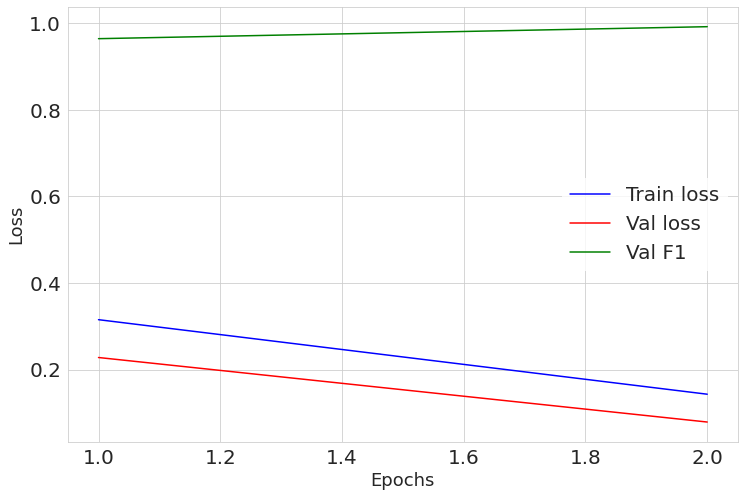

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')  # Set the plot style

# Set the figure size
plt.figure(figsize=(12, 8))

# Plot the lines
plt.plot(range(1, num_epochs + 1), learning_rate_curve.train_losses, label="Train loss",color='blue')
plt.plot(range(1, num_epochs + 1), learning_rate_curve.val_losses, label="Val loss",color='red')
plt.plot(range(1, num_epochs + 1), learning_rate_curve.f1_scores, label="Val F1",color='green')

# Set the x and y labels and font sizes
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Loss', fontsize=18)

# Add a legend and customize it
plt.legend(loc='best', fontsize=50)
legend = plt.legend(fontsize=20)
legend.get_frame().set_linewidth(0.0)

# Show the plot
plt.yticks(fontsize = 20)
plt.xticks(fontsize = 20)

plt.show()


# Dev set evaluation

In [ ]:
# Uncomment if model's already trained

model_name = '/content/drive/MyDrive/NLPClassification_40/models/pcl_roberta_finetuned/'
model = RobertaPCL.from_pretrained(model_name).to('cuda')


loading configuration file /content/drive/MyDrive/NLPClassification_40/models/pcl_roberta_finetuned/config.json
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaPCL"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.26.1",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

loading weights file /content/drive/MyDrive/NLPClassification_40/models/pcl_roberta_finetuned/pytorch_model.bin
All model checkpoint weights were used when initializing RobertaPCL.

All the weight

In [ ]:
test_dataset = PCLDataset(tokenizer, test_set, augment=True)

test_dataset_short = PCLDataset(tokenizer, test_set[test_set['length'] > 0].reset_index(drop=True), augment=True)
test_loader = DataLoader(test_dataset_short , batch_size=32, collate_fn=test_dataset.collate_fn)

tot_preds = []
labels = []
with torch.no_grad():
    model.eval()
    for batch in (test_loader):
        batch = batch.to(torch.device('cuda'))
        label = batch.pop('label')
        extra = batch.pop('extra')
        logits = model(extra, **batch)
        
        preds = logits.argmax(axis=1)
        tot_preds.extend(list(preds.cpu().numpy()))
        labels.extend(list(label.cpu().numpy()))

print(Counter(tot_preds))

print(f1_score(labels, tot_preds, zero_division=0))

Counter({0: 1900, 1: 193})
0.5612244897959183


precision: 0.3319672131147541
recall： 0.8140703517587939
f1_score: 0.47161572052401735


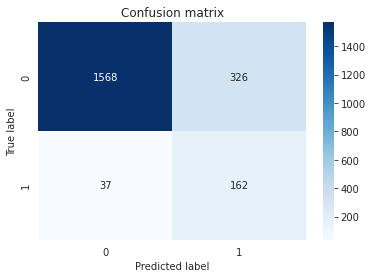

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
print('precision: ' + str(precision_score(labels, tot_preds)))
print( 'recall： ' + str(recall_score(labels, tot_preds)))
print('f1_score: ' + str(f1_score(labels, tot_preds)))

# Display the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(labels, tot_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
print(f'Development set length = {len(test_set)}')
print(f'Predictions  length = {len(tot_preds)}')

labels2file([[k] for k in tot_preds], './res/task1.txt')
labels2file(test_set.label.apply(lambda x:[x]).tolist(), './ref/task1.txt')

Development set length = 2093
Predictions  length = 2093


In [ ]:
module_url = f"https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/evaluation.py"
module_name = module_url.split('/')[-1]
print(f'Fetching {module_url}')
#with open("file_1.txt") as f1, open("file_2.txt") as f2
with request.urlopen(module_url) as f, open(module_name,'w') as outf:
  a = f.read()
  outf.write(a.decode('utf-8'))

Fetching https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/evaluation.py


## Scores for different lengths

In [ ]:
# f1 for different lengths

short_len = 0.05
long_len = 0.25 

test_dataset_short = PCLDataset(tokenizer, test_set[test_set['length'] > long_len].reset_index(drop=True), augment=True)
test_loader = DataLoader(test_dataset_short , batch_size=32, collate_fn=test_dataset.collate_fn)

preds = []
labels = []

with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(torch.device('cuda'))
        label = batch.pop('label')
        extra = batch.pop('extra')
        
        logits = model(extra, **batch)
        
        preds.extend(list(logits.argmax(dim=-1).cpu().numpy()))
        labels.extend(list(label.cpu().numpy()))


print(f1_score(labels, preds, zero_division=0))

0.4794520547945206


# Submission

In [ ]:
submission_set['label'] = -1

submission_dataset = PCLDataset(tokenizer, submission_set, augment=True)
submission_loader = DataLoader(submission_dataset, batch_size=32, collate_fn=submission_dataset.collate_fn)

tot_preds = []
with torch.no_grad():
    model.eval()
    for batch in (submission_loader):
        batch = batch.to(torch.device('cuda'))
        labels = batch.pop('label')
        extra = batch.pop('extra')
        logits = model(extra, **batch)
        
        preds = logits.argmax(axis=1)
        tot_preds.extend(list(preds.cpu().numpy()))


labels2file([[k] for k in tot_preds], './task1.txt')


In [ ]:
!zip submission.zip task1.txt